# Focal Loss

Focal loss aims to solve class imbalance problem. It's common to have very few positive examples and a vast amount of negative examples in a given dataset. Using conventional cross entropy loss incentivizes the net to predict negative for all inputs. We want to avoid this by limiting the loss contribution from negative examples using focal loss; our "focal point" is on the positives.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Dummy Example

I have a ground truth target vector with mostly zero's in it.

In [24]:
p = np.random.uniform(low=0, high=1, size=(10,))
y = np.zeros(10) # Dominated by 0s
y[0] = 1
print(f"Predictions: {np.round(p, 2)}")
print(f"Ground Truths: {y}")

Predictions: [0.4  0.75 0.25 0.25 0.89 0.53 0.28 0.57 0.77 0.21]
Ground Truths: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Cross entropy loss will be dominated by the mis-classification of negative examples.

In [6]:
def cross_entropy_loss(p: np.ndarray, y: np.ndarray):
    """Not numerically stable, it can divide by 0"""
    assert p.shape == y.shape
    losses = np.zeros(len(p))
    losses[y == 1] = -np.log(p[y == 1])
    losses[y == 0] = -np.log(1 - p[y == 0])
    return losses

In [7]:
print("CE losses from random examples", cross_entropy_loss(p, y).sum())
print("CE losses from all correct predictions", cross_entropy_loss(y, y).sum())

CE losses from random examples 8.444698862483094
CE losses from all correct predictions 0.0


## Formulation

Let

$$
\begin{equation}
    p_t = 
    \begin{cases}
        p, & \text{if} \ y=1 \\
        1-p, & \text{otherwise}
    \end{cases}
\end{equation}
$$

The $\alpha_t$ is a weighted hyperparameter term. Higher alpha means positive examples contribute more to the loss. If alpha is 1, negative examples don't contribute any to the loss. It gives high weights to the rare class and small weights to the dominating or common class.

- $\alpha$ for positive class
- $1 - \alpha$ for negative class

The $\gamma$ is another hyperparameter that controls the shape of the loss curve. The higher value of $\gamma$, the lower the loss for well-classified examples, so we could turn the attention of the model more towards hard-to-classify examples. Having high $\gamma$ extends the range in which an example receives low loss.

$$
\begin{equation}
    \text{Focal Loss}(p, y) = 
    \begin{cases}
        -\alpha(1 - p)^{\gamma}log(p), & \text{if} \ y=1 \\
        -(1 - \alpha)p^{\gamma}log(1-p), & \text{otherwise}
    \end{cases}
\end{equation}
$$

In [23]:
def focal_loss(p: np.ndarray, y: np.ndarray, alpha: float, gamma: float):
    assert p.shape == y.shape
    losses = np.zeros(len(p))
    losses[y == 1] = -alpha * (1 - p[y == 1])**gamma * np.log(p[y == 1])
    losses[y == 0] = -(1 - alpha)*p[y == 0]**gamma * np.log(1 - p[y == 0])
    return losses

print("Focal losses from random examples:", np.round(focal_loss(p, y, alpha=1, gamma=2), 2))
print("Focal losses from all correct predictions:", focal_loss(y, y, alpha=1, gamma=2))

## Effects of Alpha

When alpha is 1, notice that only mis-classifcation of positive examples contributes to loss.

In [12]:
print(np.round(focal_loss(p, y, alpha=1, gamma=0), 2))

[ 2.86 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  ]


When alpha is 0, notice that only mis-classifcation of negative examples contributes to loss.

In [13]:
print(np.round(focal_loss(p, y, alpha=0, gamma=0), 2))

[-0.    0.08  0.39  1.42  0.41  0.15  1.92  0.37  0.83  0.02]


When alpha is 0.5, the loss is still mainly contributed by the mis-classification of positive example.

In [14]:
np.round(focal_loss(p, y, alpha=0.5, gamma=0), 2)

array([1.43, 0.04, 0.19, 0.71, 0.2 , 0.08, 0.96, 0.18, 0.41, 0.01])

## Effects of Gamma

Gamma controls the shape of the loss contribution from positive/negative example. At very high gamma, the loss contribution sharply increases only when prediction is very far off from target.

In [57]:
p = np.array([1e-2, 0, 0, 0, 0])
y = np.array([1, 0, 0, 0, 0])
print("High Gamma", np.round(focal_loss(p, y, alpha=1, gamma=100), 2))
print("Low Gamma", np.round(focal_loss(p, y, alpha=1, gamma=1e-5), 2))

High Gamma [1.69 0.   0.   0.   0.  ]
Low Gamma [4.61 0.   0.   0.   0.  ]


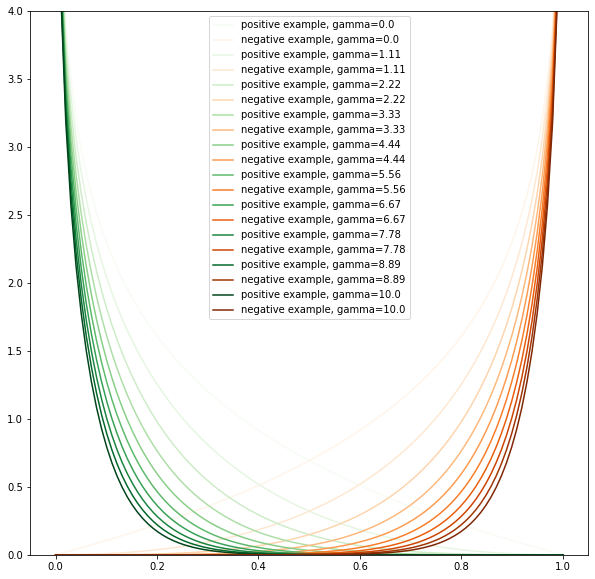

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 10))
positives = np.ones(100)
negatives = np.zeros(100)
p = np.linspace(1e-5, 1-1e-5, 100)

greens = plt.cm.get_cmap('Greens')(np.linspace(0, 1, 10))
oranges = plt.cm.get_cmap('Oranges')(np.linspace(0, 1, 10))
for i, gamma in enumerate(np.linspace(0, 10, 10)):
    ax.plot(p, focal_loss(p, positives, alpha=1, gamma=gamma),
            color=greens[i],
            label=f"positive example, gamma={np.round(gamma, 2)}")
    ax.plot(p, focal_loss(p, negatives, alpha=0, gamma=gamma),
            color=oranges[i],
            label=f"negative example, gamma={np.round(gamma, 2)}")
ax.legend(loc='upper center')
ax.set_ylim(0, 4)
plt.show()

## Pixel-wise Classification Example

We want to detect key points on an image. For example, facial detection requires knowing location of the eyes, nose and mouth. We may get 4 key points for a given image. Each keypoint may be represented by a Gaussian. For simplicity, I won't draw a face here. I will use a simple zero'ed matrix with keypoints to represent the target.

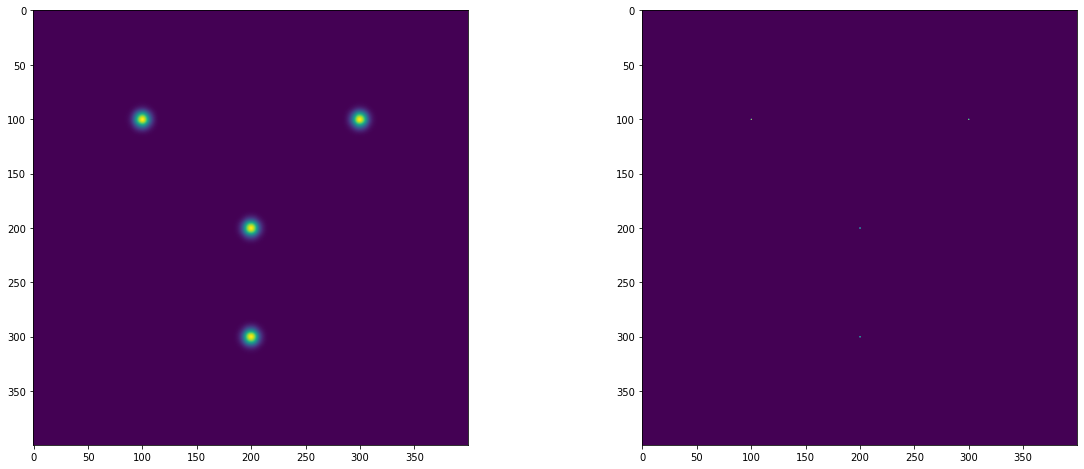

In [79]:
target = np.zeros((400, 400, 1))
mask = np.zeros((400, 400, 1))

xstd = 5.0
ystd = 5.0

for u, v in [(100, 100), (300, 100), (200, 200), (200, 300)]:
    u_ind = np.arange(target.shape[1], dtype=np.float32)
    v_ind = np.arange(target.shape[0], dtype=np.float32)
    u_ind, v_ind = np.meshgrid(u_ind, v_ind)
    gaussian_xterm = np.power(u_ind - u, 2) / ((2 * np.power(xstd, 2)))
    gaussian_yterm = np.power(v_ind - v, 2) / ((2 * np.power(ystd, 2)))
    gaussian = np.exp(-1 * (gaussian_xterm + gaussian_yterm))
    target[:, :, 0] = np.maximum(target[:, :, 0], gaussian)
    mask[v, u, 0] = 1.0

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(target)
axs[1].imshow(mask)

Suppose we have a noisy initial sigmoid prediction from the network:

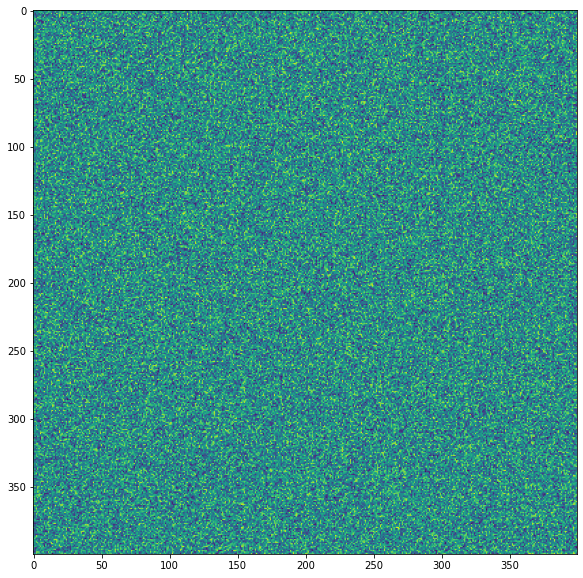

In [84]:
pred = np.random.randn(400, 400, 1)
pred_sigmoid = 1/(1 + np.exp(-pred))

fig, axs = plt.subplots(1, figsize=(10, 10))
axs.imshow(pred_sigmoid)

## Object as Points Focal Loss

In [Objects as Points](https://arxiv.org/pdf/1904.07850.pdf), the focal loss is defined slightly different from the original focal loss. The gamma term has been replaced. Instead we have an alpha and beta term.

The positive loss term from this version of focal loss is defined as

$$
-1 * \text{positive mask}\left[(1 - p)^{\alpha}log(p)\right]
$$

The negative loss term is defined as

$$
-1 * \text{negative mask}\left[p^{\alpha}(1 - y)^{\beta}log(1-p)\right]
$$


In [90]:
alpha = 2.0
beta = 4.0
positive_loss = -1 * (mask * np.power(1 - pred_sigmoid, alpha) * np.log(pred_sigmoid))
negative_loss = -1 * (1 - mask) * np.power(pred_sigmoid, alpha) * np.power(1 - target, beta) * np.log(1 - pred_sigmoid)
print('Total Loss', positive_loss.sum() + negative_loss.sum())

Total Loss 54805.340572367386


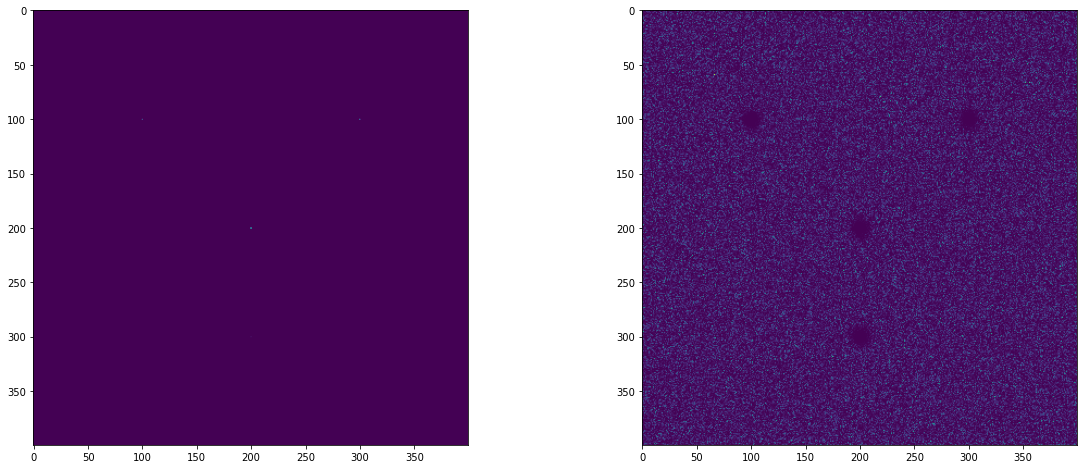

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(positive_loss)
axs[1].imshow(negative_loss)